In [6]:
import cv2
import matplotlib.pyplot as plt
from pspnet_segmentation import PSPNetSematicSegmentation
import numpy as np
from helpers import load_images_from_folder
import time

In [7]:
seg = PSPNetSematicSegmentation()

[2021-08-07 18:48:53,985 INFO pspnet_segmentation.py line 62 22] => loading checkpoint 'semseg/exp/ade20k/pspnet50/model/train_epoch_100.pth'
[2021-08-07 18:48:53,985 INFO pspnet_segmentation.py line 62 22] => loading checkpoint 'semseg/exp/ade20k/pspnet50/model/train_epoch_100.pth'
[2021-08-07 18:48:53,985 INFO pspnet_segmentation.py line 62 22] => loading checkpoint 'semseg/exp/ade20k/pspnet50/model/train_epoch_100.pth'
[2021-08-07 18:48:53,985 INFO pspnet_segmentation.py line 62 22] => loading checkpoint 'semseg/exp/ade20k/pspnet50/model/train_epoch_100.pth'
[2021-08-07 18:48:53,985 INFO pspnet_segmentation.py line 62 22] => loading checkpoint 'semseg/exp/ade20k/pspnet50/model/train_epoch_100.pth'
[2021-08-07 18:48:54,241 INFO pspnet_segmentation.py line 65 22] => loaded checkpoint 'semseg/exp/ade20k/pspnet50/model/train_epoch_100.pth'
[2021-08-07 18:48:54,241 INFO pspnet_segmentation.py line 65 22] => loaded checkpoint 'semseg/exp/ade20k/pspnet50/model/train_epoch_100.pth'
[2021-08

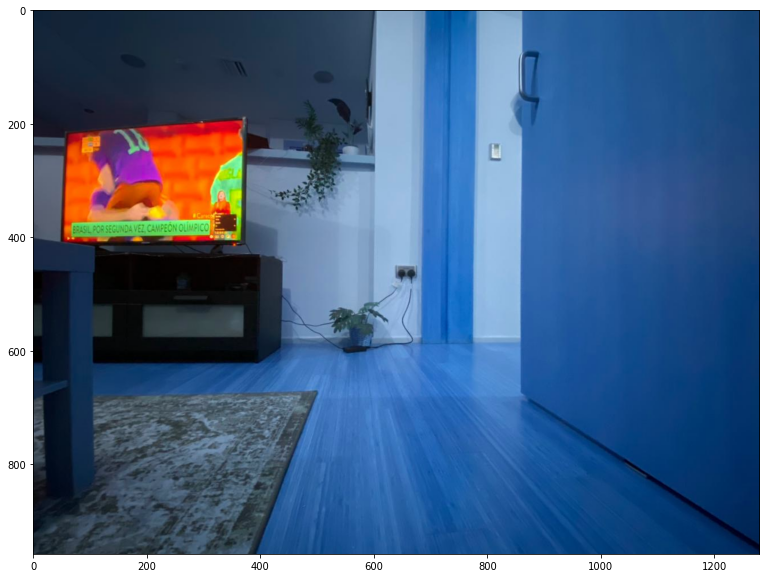

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(img)
plt.show()

avg time: 4.105803728103638


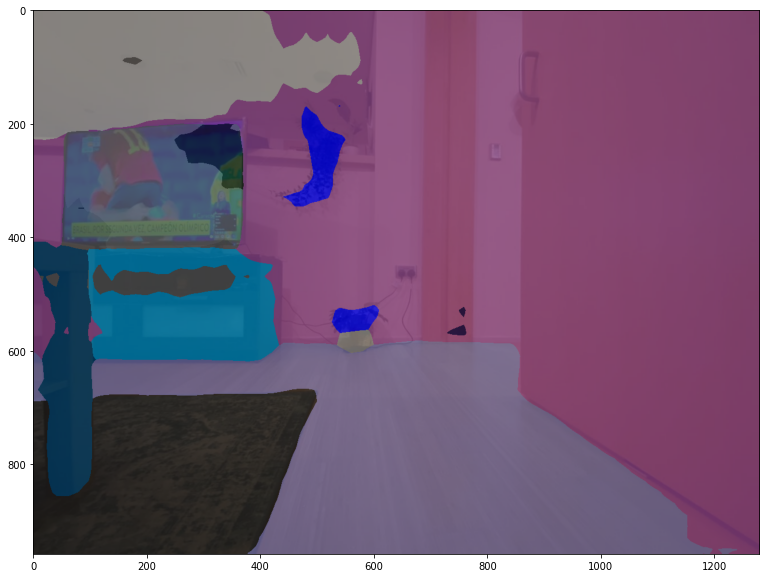

In [18]:
img = cv2.imread("./data/jackal_cam/01.jpeg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert cv2 read image from BGR order to RGB order
start = time.time()
segmented_img = seg.process_img(img)
end = time.time()
print('avg time: {}'.format(end-start))
segmented_img = cv2.addWeighted(img, 0.2, segmented_img, 0.8, 0)  
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(segmented_img)
plt.show()

In [19]:
imgs, filenames = load_images_from_folder('./data/jackal_cam')
print('processing {} images'.format(len(imgs)))
i=0

start = time.time()

for img, filename in zip(imgs, filenames):
    print('===============File: {} ============'.format(filename))
    segmented_img = seg.process_img(img)
    segmented_img = cv2.addWeighted(img, 0.2, segmented_img, 0.8, 0)  
    cv2.imwrite('./output/out2/{}'.format(filename), segmented_img)
    i = i+1
end = time.time()
print('avg time: {}'.format((end-start)/len(imgs)))

processing 115 images
===============File: left2330.jpg ============
===============File: left2519.jpg ============
===============File: left2453.jpg ============
===============File: left2354.jpg ============
===============File: left2411.jpg ============
===============File: left2316.jpg ============
===============File: left2298.jpg ============
===============File: left2480.jpg ============
===============File: left2421.jpg ============
===============File: left2399.jpg ============
===============File: left2475.jpg ============
===============File: left2444.jpg ============
===============File: left2289.jpg ============
===============File: left2325.jpg ============
===============File: left2307.jpg ============
===============File: left2447.jpg ============
===============File: left2361.jpg ============
===============File: left2384.jpg ============
===============File: left2372.jpg ============
===============File: left2385.jpg ============
===============File: left2291.jpg ====

In [4]:
print(segmented_img.dtype)
print(np.unique(segmented_img))
print(segmented_img.shape)


float64
[  0.  20.  35.  60.  64.  70.  80. 100. 107. 128. 142. 152. 153. 190.
 220. 232. 244. 251.]
(720, 1280, 3)


In [11]:
segmented_img = cv2.cvtColor(segmented_img, cv2.COLOR_BGR2GRAY)  # convert cv2 read image from BGR order to RGB order

print(segmented_img.dtype)
print(np.unique(segmented_img))
print(segmented_img.shape)

def decode_segmap(temp,label_colours):
        r = temp.copy()
        g = temp.copy()
        b = temp.copy()
        for l in range(0, 19):
            r[temp == l] = label_colours[l][0]
            g[temp == l] = label_colours[l][1]
            b[temp == l] = label_colours[l][2]
        rgb = np.zeros((temp.shape[0], temp.shape[1], 3))
        rgb[:, :, 0] = r / 255.0
        rgb[:, :, 1] = g / 255.0
        rgb[:, :, 2] = b / 255.0
        return rgb

uint8
[ 0  1  2  4  5  7  8  9 11 14 16]
(720, 1280)


In [12]:
colors = [  # [  0,   0,   0],
            [128, 64, 128],
            [244, 35, 232],
            [70, 70, 70],
            [102, 102, 156],
            [190, 153, 153],
            [153, 153, 153],
            [250, 170, 30],
            [220, 220, 0],
            [107, 142, 35],
            [152, 251, 152],
            [0, 130, 180],
            [220, 20, 60],
            [255, 0, 0],
            [0, 0, 142],
            [0, 0, 70],
            [0, 60, 100],
            [0, 80, 100],
            [0, 0, 230],
            [119, 11, 32],
        ]
label_colours = dict(zip(range(19), colors))
decoded = decode_segmap(temp=segmented_img.copy(),label_colours=label_colours)

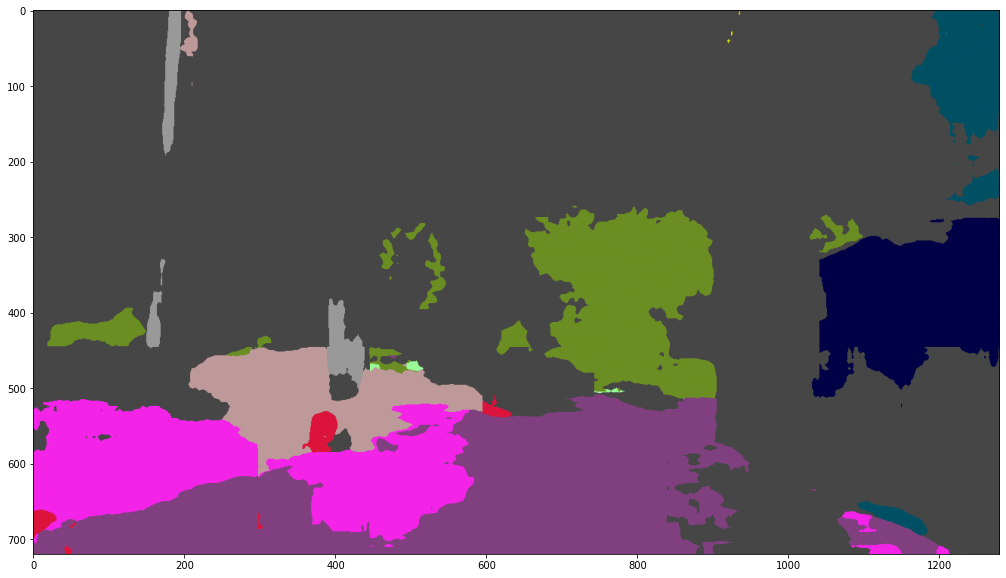

In [13]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(decoded)
plt.show()

In [1]:
import sys
sys.path.append("/usr/src/app/dev_ws/src/vision/vision/semseg")
import os
import logging
import argparse
import cv2
import numpy as np
import torch
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.nn.parallel
import torch.utils.data

from util import config
from util.util import colorize

cv2.ocl.setUseOpenCL(False)

In [2]:
def get_parser():
    cfg = config.load_cfg_from_cfg_file("semseg/config/cityscapes/cityscapes_pspnet101.yaml")
    cfg.image = "data/jackal_cam/left1863.jpg"
    
#     cfg.image = "semseg/figure/demo/ADE_val_00001515.jpg"
    return cfg

def get_logger():
    logger_name = "main-logger"
    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.INFO)
    handler = logging.StreamHandler()
    fmt = "[%(asctime)s %(levelname)s %(filename)s line %(lineno)d %(process)d] %(message)s"
    handler.setFormatter(logging.Formatter(fmt))
    logger.addHandler(handler)
    return logger



In [9]:
args = get_parser()
logger = get_logger()
logger.info(args)
os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(str(x) for x in args.test_gpu)
value_scale = 255
mean = [0.485, 0.456, 0.406]
mean = [item * value_scale for item in mean]
std = [0.229, 0.224, 0.225]
std = [item * value_scale for item in std]
colors = np.loadtxt(args.colors_path).astype('uint8')

[2021-08-05 14:04:39,939 INFO 2522706813.py line 3 236] arch: psp
aux_weight: 0.4
base_lr: 0.01
base_size: 2048
batch_size: 16
batch_size_val: 8
classes: 19
colors_path: semseg/data/cityscapes/cityscapes_colors.txt
data_root: semseg/dataset/cityscapes
dist_backend: nccl
dist_url: tcp://127.0.0.1:6789
epochs: 200
evaluate: False
has_prediction: False
ignore_label: 255
image: data/jackal_cam/left1863.jpg
index_start: 0
index_step: 0
layers: 101
manual_seed: None
model_path: semseg/exp/cityscapes/pspnet101/model/train_epoch_200.pth
momentum: 0.9
multiprocessing_distributed: True
names_path: semseg/data/cityscapes/cityscapes_names.txt
power: 0.9
print_freq: 10
rank: 0
resume: None
rotate_max: 10
rotate_min: -10
save_folder: semseg/exp/cityscapes/pspnet101/result/epoch_200/val/ss
save_freq: 1
save_path: exp/cityscapes/pspnet101/model
scale_max: 2.0
scale_min: 0.5
scales: [1.0]
split: val
start_epoch: 0
sync_bn: True
test_gpu: [0]
test_h: 713
test_list: semseg/dataset/list/cityscapes/fine_va

In [10]:
if args.arch == 'psp':
    from model.pspnet import PSPNet
    model = PSPNet(layers=args.layers, classes=args.classes, zoom_factor=args.zoom_factor, pretrained=False)
elif args.arch == 'psa':
    from model.psanet import PSANet
    model = PSANet(layers=args.layers, classes=args.classes, zoom_factor=args.zoom_factor, compact=args.compact,
                       shrink_factor=args.shrink_factor, mask_h=args.mask_h, mask_w=args.mask_w,
                       normalization_factor=args.normalization_factor, psa_softmax=args.psa_softmax, pretrained=False)
model = torch.nn.DataParallel(model).cuda()
cudnn.benchmark = True


In [11]:
def net_process(model, image, mean, std=None, flip=True):
    input = torch.from_numpy(image.transpose((2, 0, 1))).float()
    if std is None:
        for t, m in zip(input, mean):
            t.sub_(m)
    else:
        for t, m, s in zip(input, mean, std):
            t.sub_(m).div_(s)
    input = input.unsqueeze(0).cuda()
    if flip:
        input = torch.cat([input, input.flip(3)], 0)
    with torch.no_grad():
        output = model(input)
    _, _, h_i, w_i = input.shape
    _, _, h_o, w_o = output.shape
    if (h_o != h_i) or (w_o != w_i):
        output = F.interpolate(output, (h_i, w_i), mode='bilinear', align_corners=True)
    output = F.softmax(output, dim=1)
    if flip:
        output = (output[0] + output[1].flip(2)) / 2
    else:
        output = output[0]
    output = output.data.cpu().numpy()
    output = output.transpose(1, 2, 0)
    return output


def scale_process(model, image, classes, crop_h, crop_w, h, w, mean, std=None, stride_rate=2/3):
    ori_h, ori_w, _ = image.shape
    pad_h = max(crop_h - ori_h, 0)
    pad_w = max(crop_w - ori_w, 0)
    pad_h_half = int(pad_h / 2)
    pad_w_half = int(pad_w / 2)
    if pad_h > 0 or pad_w > 0:
        image = cv2.copyMakeBorder(image, pad_h_half, pad_h - pad_h_half, pad_w_half, pad_w - pad_w_half, cv2.BORDER_CONSTANT, value=mean)
    new_h, new_w, _ = image.shape
    stride_h = int(np.ceil(crop_h*stride_rate))
    stride_w = int(np.ceil(crop_w*stride_rate))
    grid_h = int(np.ceil(float(new_h-crop_h)/stride_h) + 1)
    grid_w = int(np.ceil(float(new_w-crop_w)/stride_w) + 1)
    prediction_crop = np.zeros((new_h, new_w, classes), dtype=float)
    count_crop = np.zeros((new_h, new_w), dtype=float)
    for index_h in range(0, grid_h):
        for index_w in range(0, grid_w):
            s_h = index_h * stride_h
            e_h = min(s_h + crop_h, new_h)
            s_h = e_h - crop_h
            s_w = index_w * stride_w
            e_w = min(s_w + crop_w, new_w)
            s_w = e_w - crop_w
            image_crop = image[s_h:e_h, s_w:e_w].copy()
            count_crop[s_h:e_h, s_w:e_w] += 1
            prediction_crop[s_h:e_h, s_w:e_w, :] += net_process(model, image_crop, mean, std)
    prediction_crop /= np.expand_dims(count_crop, 2)
    prediction_crop = prediction_crop[pad_h_half:pad_h_half+ori_h, pad_w_half:pad_w_half+ori_w]
    prediction = cv2.resize(prediction_crop, (w, h), interpolation=cv2.INTER_LINEAR)
    return prediction


def test(model, image_path, classes, mean, std, base_size, crop_h, crop_w, scales, colors):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)  # BGR 3 channel ndarray wiht shape H * W * 3
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert cv2 read image from BGR order to RGB order
    h, w, _ = image.shape
    prediction = np.zeros((h, w, classes), dtype=float)
    for scale in scales:
        long_size = round(scale * base_size)
        new_h = long_size
        new_w = long_size
        if h > w:
            new_w = round(long_size/float(h)*w)
        else:
            new_h = round(long_size/float(w)*h)
        image_scale = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
        prediction += scale_process(model, image_scale, classes, crop_h, crop_w, h, w, mean, std)
    prediction = scale_process(model, image_scale, classes, crop_h, crop_w, h, w, mean, std)
    prediction = np.argmax(prediction, axis=2)
    gray = np.uint8(prediction)
    color = colorize(gray, colors)
    image_name = image_path.split('/')[-1].split('.')[0]
    gray_path = os.path.join('./semseg/figure/demo/', image_name + '_gray.png')
    color_path = os.path.join('./semseg/figure/demo/', image_name + '_color.png')
    cv2.imwrite(gray_path, gray)
    color.save(color_path)
    logger.info("=> Prediction saved in {}".format(color_path))

In [12]:


test(model.eval(), args.image, args.classes, mean, std, args.base_size, args.test_h, args.test_w, args.scales, colors)

    

[2021-08-05 14:04:41,380 INFO 1008927541.py line 2 236] => loading checkpoint 'semseg/exp/cityscapes/pspnet101/model/train_epoch_200.pth'
[2021-08-05 14:04:41,380 INFO 1008927541.py line 2 236] => loading checkpoint 'semseg/exp/cityscapes/pspnet101/model/train_epoch_200.pth'
[2021-08-05 14:04:48,674 INFO 1008927541.py line 5 236] => loaded checkpoint 'semseg/exp/cityscapes/pspnet101/model/train_epoch_200.pth'
[2021-08-05 14:04:48,674 INFO 1008927541.py line 5 236] => loaded checkpoint 'semseg/exp/cityscapes/pspnet101/model/train_epoch_200.pth'
[2021-08-05 14:05:05,399 INFO 3694138337.py line 84 236] => Prediction saved in ./semseg/figure/demo/left1863_color.png
[2021-08-05 14:05:05,399 INFO 3694138337.py line 84 236] => Prediction saved in ./semseg/figure/demo/left1863_color.png
